# DNN for GW parameter estimation
GW waveform template obtained from Wenfan
Try to create a GW waveform template bank with TianQin noise and train a DNN model to estiamte GW parameter space and compare it with traditional MCMC method.

In [1]:
'''
code below offered by Wenfan.
2020/12/25
Merry Chrismas
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from scipy import signal
from scipy.fftpack import fft,ifft
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM

In [2]:
# constants set up
'''
    mutable paramters: Phic, ThetaS, Phis, Iota, Psi, M1, M2
'''
MsunInS = 4.926860879228572e-06   # solar mass in [s]
MpcInS  = 102927125053532.6       # mega parsec in [s]
OrbitRadiusInS = 1e8 /const.c.value    # 1e5 km
MearthInS      = const.M_earth.value*const.G.value/const.c.value**3
OrbitPeriodInS = 2*np.pi*np.sqrt(OrbitRadiusInS**3/MearthInS)
YearInS  = 31536000.0 + 100  # one year in [s]
AUInS   = const.au.value/const.c.value  # AU in [s]
Tc     = 0.49*YearInS    # chirp time

Phic   = 0.954    # chirp phase
ThetaS = 1.325
PhiS   = 2.04
Iota   = 1.02
Psi    = 0.658
# ThetaS = np.arccos(np.random.uniform(-1,1)) 
# PhiS   = np.random.uniform(0,2*np.pi) 
# Iota   = np.arccos(np.random.uniform(-1,1)) 
# Psi    = np.random.uniform(0,2*np.pi)  
# print(ThetaS,PhiS,Iota,Psi)

Z      = 1.0    # cosmological redshift
M1sun  = 1e7    # solar mass as unit
M2sun  = 1e6    # solar mass as unit
Tobs   = 0.5   # year as unit 
# Chi1   = 0.1    # dimensionless parameter
# Chi2   = 0.0    # dimensionless parameter
cosmo  = FlatLambdaCDM(H0=67,Om0=0.32)
DL     = cosmo.luminosity_distance(Z).value*MpcInS # Mpc in second
M1     = (1+Z)*M1sun*MsunInS   # solar mass in second
M2     = (1+Z)*M2sun*MsunInS   # solar mass in second
M      = M1 + M2               # total mass
Qmr    = M1/M2                 # mass ratio
Mu     = M1*M2/M               # reduced mass
Mc     = Mu**(3./5)*M**(2./5)  # chirp mass
Eta    = M1*M2/M**2            # symmetric mass ratio

In [3]:
def ht_respon_TQ(t, tc, phic, mc, eta, dl, thetaS, phiS, iota, psi):
    
    """
    For TianQin (one Michelson interferometer): (thetaS,phiS) is location of source,
    (thJ,phJ) is latitude and longitude of J0806 in heliocentric-ecliptic frame
    """
    
    thJ  = 1.65273
    phJ  = 2.10213
    kap = 2*np.pi/OrbitPeriodInS* t
    Dplus_TQ = np.sqrt(3.)/32*(8*np.cos(2*kap) *((3 + np.cos(2*thetaS)) *np.sin(2*(phiS - phJ))*  
            np.cos(thJ) + 2*np.sin(thJ) *np.sin(phiS - phJ)*np.sin(2*thetaS))- 2*np.sin(2*kap)* (3 +               
            np.cos(2*(phiS - phJ))*(9 + np.cos(2*thetaS)*(3 + np.cos(2*thJ))) -6 *np.cos(2*thJ)*(np.sin(phiS - phJ))**2 -               
            6* np.cos(2*thetaS)*(np.sin(thJ))**2 + 4*np.cos(phiS - phJ)*np.sin(2*thJ)*np.sin(2*thetaS))) 
    
    Dcros_TQ = np.sqrt(3.)/4*(-4*np.cos(2*kap)*(np.cos(2*(phiS-phJ))*np.cos(thJ)*np.cos(thetaS)+                 
            np.cos(phiS-phJ)*np.sin(thetaS)*np.sin(thJ))+np.sin(2*kap)*(np.cos(thetaS)*(3+np.cos(2*thJ))*np.sin(2*(phJ-phiS))+                
            2*np.sin(phJ-phiS)*np.sin(thetaS)*np.sin(2*thJ)))

    #"""antenna pattern function for '+' mode"""
    Fplus_TQ = (np.cos(2*psi)*Dplus_TQ-np.sin(2*psi)*Dcros_TQ)/2.

    #"""antenna pattern function for '×' mode"""
    Fcros_TQ = (np.sin(2*psi)*Dplus_TQ+np.cos(2*psi)*Dcros_TQ)/2.

    #"""1st MI angular response function for TianQin"""
    Q_TQ = np.sqrt((1+(np.cos(iota))**2)**2/4*(Fplus_TQ)**2 
             +(np.cos(iota))**2*(Fcros_TQ)**2)

    #"""1st MI polarization phase for TianQin"""
    phip_TQ = -np.arctan(2*np.cos(iota)*Fcros_TQ/((1+(np.cos(iota))**2)*Fplus_TQ))  

    #"""non-precesnp.sing spinning PN correction to the orbital phase"""
    THETA = eta*(tc-t)/(5*mc/eta**(3./5))
    PSI_PN = phic-THETA**(5./8)/eta *(1 \
           + (3715./8064 + 55./96*eta)*THETA**(-1./4) \
           - 3*np.pi/4*THETA**(-3./8)  \
           + (9275495./14450688+284875./258048*eta+1855./2048*eta**2)*THETA**(-1./2)) 

    # """the frequency-domain amplitude: 1st 60 degree MI with antenna response (contain plus and cross mode) for TianQin"""
    ht_TQ = -mc*Q_TQ/dl*((tc-t)/(5*mc))**(-1./4)*np.cos(phip_TQ+2*PSI_PN)
#     ht_TQ = np.concatenate([ht_TQ, len(t)*[0]])
    return ht_TQ

In [4]:
def ht_respon_LISA(t, tc, phic, mc, eta, dl, thetaS, phiS, iota, psi):
    
    """For LISA (one Michelson interferometer): (thetaS,phiS) is location of source"""
#     alpha = 2*np.pi/YearInS* t-np.pi/9 # trailing 20°behind the Earth (-np.pi/9)
    alpha = 2*np.pi/YearInS* t 
    lam = 3*np.pi/4
    Dplus_LISA = np.sqrt(3.)/64*(-36*(np.sin(thetaS))**2 *np.sin(2*alpha-2*lam) +(3+np.cos(2*thetaS))*(np.cos(2*phiS)*(9*np.sin(2*lam)-np.sin(4*alpha-2*lam)) \
            + np.sin(2*phiS)*(np.cos(4*alpha-2*lam)-9*np.cos(2*lam)))-4*np.sqrt(3.)*np.sin(2*thetaS)*(np.sin(3*alpha-2*lam-phiS)-3*np.sin(alpha-2*lam+phiS)))
    
    Dcros_LISA = 1/16*(np.sqrt(3.)*np.cos(thetaS)*(9*np.cos(2*lam-2*phiS)-np.cos(4*alpha-2*lam-2*phiS))-6*np.sin(thetaS)*(np.cos(3*alpha-2*lam-phiS)+3*np.cos(alpha-2*lam+phiS)))
    
    #"""antenna pattern function for '+' mode"""
    Fplus_LISA = (np.cos(2*psi)*Dplus_LISA-np.sin(2*psi)*Dcros_LISA)/2.

    #"""antenna pattern function for '×' mode"""
    Fcros_LISA = (np.sin(2*psi)*Dplus_LISA+np.cos(2*psi)*Dcros_LISA)/2.

    #"""1st MI angular response function for TianQin"""
    Q_LISA = np.sqrt((1+(np.cos(iota))**2)**2/4*(Fplus_LISA)**2 
             +(np.cos(iota))**2*(Fcros_LISA)**2)

    #"""1st MI polarization phase for TianQin"""
    phip_LISA = -np.arctan(2*np.cos(iota)*Fcros_LISA/((1+(np.cos(iota))**2)*Fplus_LISA))  

    #"""non-precesnp.np.sing spinning PN correction to the GW phase"""
    THETA = eta*(tc-t)/(5*mc/eta**(3./5))
    PSI_PN = phic-THETA**(5./8)/eta *(1 \
           + (3715./8064 + 55./96*eta)*THETA**(-1./4) \
           - 3*np.pi/4*THETA**(-3./8)  \
           + (9275495./14450688+284875./258048*eta+1855./2048*eta**2)*THETA**(-1./2)) 

    # """the frequency-domain amplitude: 1st 60 degree MI with antenna response (contain plus and cross mode) for TianQin"""
    ht_LISA = -mc*Q_LISA/dl*((tc-t)/(5*mc))**(-1./4)*np.cos(phip_LISA+2*PSI_PN)
    return ht_LISA

In [5]:
# def ht_model(t, tc, phic, mc, eta, dl, thetaS, phiS, iota, psi):
#     ht = np.piecewise(t, [t >= tc, t < tc], 
#                       [0, partial(ht_respon_TQ, tc=tc, phic=phic, mc=mc, eta=eta, dl=dl, thetaS=thetaS, phiS=phiS, iota=iota, psi=psi)])
#     return ht

def ht_model(t, tc, phic, mc, eta, dl, thetaS, phiS, iota, psi):
    ht = np.piecewise(t, [t >= tc, t < tc], 
                      [0, partial(ht_respon_LISA, tc=tc, phic=phic, mc=mc, eta=eta, dl=dl, thetaS=thetaS, phiS=phiS, iota=iota, psi=psi)])
    return ht

# Convert noise PSD to time series PSD -> n(t)

In [6]:
def TQPSD(f):
    """CQG 2018"""
    Sx = 1e-24
    Sa = 1e-30
    L0 = np.sqrt(3.)*1e5 *1e3
    return (Sx/(L0**2)+ 4*Sa/((2*np.pi*f)**4*L0**2)*(1.+ 1e-4/f))

def LISAPSD(f):
    """MCMC of SMBHB, Cornish and Porter, CQG 2006"""
    Spos = 4e-22
    Sacc = 9e-30
    L = 5e9
    return (4*Spos+ 16*Sacc/(2*np.pi*f)**4)/(4*L**2)

In [7]:
### ref：https://groups.google.com/g/comp.soft-sys.matlab/c/tmw2H26MDtI
def psd2timeseries(PSD, fmax):
    '''
        x = time series
        t = time vector
        PSD = power spectral density (one-sided, from 0 to fNyq)
        fmax = max frequecy can reach if fmax < Nyquist frequency
    '''
    
    N = len(PSD)

    # Sampling of frequency vector
    delta_f = fmax/(N-1)

    # Compute amplitude of frequency spectrum
    # multiply PSD by fs*N=2*fNyq*N (a factor to match)
    SpectrumAmplitude = np.sqrt(PSD*2*fmax*N)

    # Compute phase of frequency spectrum
    SpectrumPhase = np.random.rand(len(PSD))*2*np.pi

    # Compute complex spectrum
    Spectrum = SpectrumAmplitude*np.exp(1j*SpectrumPhase)

    # Generate the two-sided PSD:
    end = len(Spectrum)
    Spectrum_TwoSided = np.concatenate([Spectrum[0:end:1], np.conj(Spectrum[end-2:0:-1])])

    # Compute inverse FFT
    x = ifft(Spectrum_TwoSided)
#     x= fftshift(x)
    x = np.real(x)

    # Compute time vector
    delta_t = 1./(2.*fmax)
    t= np.arange(0,(N-1)*delta_t,delta_t)

    return [x,t]

# Verify results

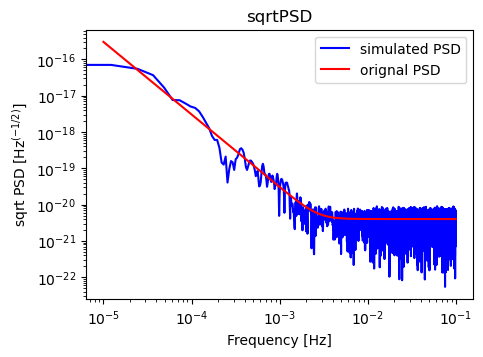

In [8]:
fs = 8192 # sampling rate 8192 Hz
fmin = 1e-5
fmax = 1e-1
df = (fmax - fmin)/fs
f = np.arange(fmin,fmax,df)

PSD = LISAPSD(f)
# PSD = TQPSD(f)

# fNyq = fs/2 # Nyquist frequency

TimeSeries = psd2timeseries(PSD,fmax)[0]
TimeVector = psd2timeseries(PSD,fmax)[1]

freq, Pxx = signal.periodogram(TimeSeries,2*fmax,window = 'flattop', scaling = 'density')
plt.figure(figsize=(5,3.5),dpi=100)
plt.loglog(freq, np.sqrt(Pxx),'b',label='simulated PSD')
plt.loglog(f,np.sqrt(PSD),'r',label='orignal PSD')
plt.title('sqrtPSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('sqrt PSD [Hz$^{(-1/2)}$]')
plt.legend()

# Data used in real simulation

sampling frequency is 18606.299 Hz


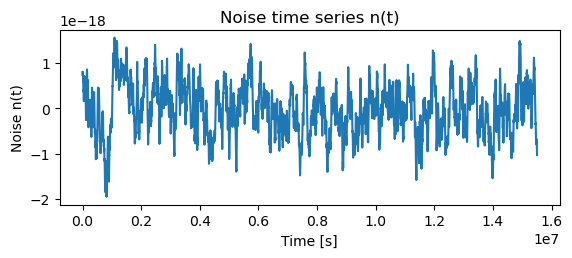

In [9]:
df = 1/YearInS
fmin = 1e-5
fmax = 6e-4
f = np.arange(fmin,fmax,df)
fs = (fmax - fmin)/df
print(f'sampling frequency is {fs} Hz')
################
# PSD = TQPSD(f)
PSD = LISAPSD(f)
################

TimeSeries = psd2timeseries(PSD, fmax)[0]
TimeVector = psd2timeseries(PSD, fmax)[1]
Noise_t = TimeSeries[1:len(f)]

fig = plt.figure(figsize=(5,3.5),dpi=100)
ax = fig.add_axes([0,0,1,0.5])
ax.plot(TimeVector,Noise_t)
ax.set_title('Noise time series n(t)')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Noise n(t)')
fig.savefig('Noise.png',dpi = 350, bbox_inches = 'tight')

# Data Model

Observation time: 0.500000 year
Sampling time interval: 833.333333 second


Text(0, 0.5, 'Data d(t)')

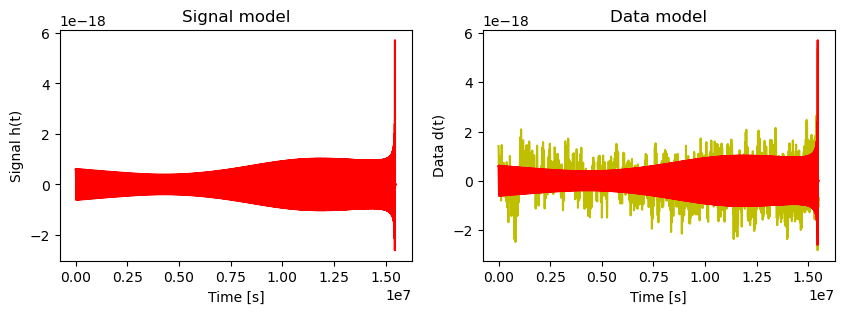

In [10]:
tc_true     = Tc
phic_true   = Phic
mc_true     = Mc
eta_true    = Eta
dl_true     = DL
thetas_true = ThetaS
phis_true   = PhiS
iota_true   = Iota
psi_true    = Psi

print('Observation time: %f year'%Tobs)
print('Sampling time interval: %f second'%(TimeVector[2]-TimeVector[1]))
h_t = ht_model(TimeVector, tc_true, phic_true, mc_true, eta_true, dl_true, thetas_true, phis_true, iota_true, psi_true)
Data = h_t + Noise_t

plt.figure(figsize=(10,3),dpi=100)
plt.subplot(1,2,1)
plt.plot(TimeVector,h_t, color='r')
plt.title('Signal model')
plt.xlabel('Time [s]')
plt.ylabel('Signal h(t)')
plt.subplot(1,2,2)
plt.plot(TimeVector,Data,color='y')
plt.plot(TimeVector,h_t, color='r')
plt.title('Data model')
plt.xlabel('Time [s]')
plt.ylabel('Data d(t)')

# Data Whitening

/opt/local/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


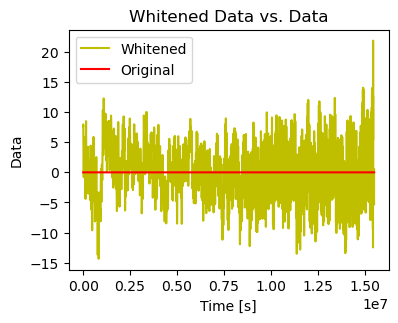

In [11]:
N = len(f)
fft_Data = np.fft.fft(Data,n=N)
white_Data = fft_Data/np.sqrt(PSD)
White_Data_t = np.fft.ifft(white_Data,n=N)

white_noise = np.random.randn(N)
white_h = np.fft.fft(h_t,N)/np.sqrt(PSD)
white_ht = np.fft.ifft(white_h,N)
white_data = white_ht + white_noise


fig = plt.figure(figsize=(4,3), dpi=100)
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(TimeVector,White_Data_t[1:len(f)],'y',label='Whitened')
axes.plot(TimeVector,Data,'r',label='Original')
axes.set_xlabel('Time [s]')
axes.set_ylabel('Data')
axes.set_title('Whitened Data vs. Data')
axes.legend(loc=0)

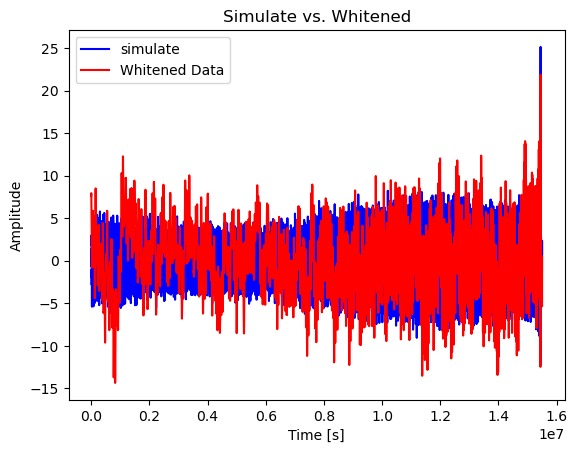

In [12]:
plt.plot(TimeVector,white_data[1:N],'b',label='simulate')
plt.plot(TimeVector,White_Data_t[1:N],'r',label='Whitened Data')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Simulate vs. Whitened')
plt.legend(loc=0)

Text(0.5, 1.0, 'Whitened Data with real color noise')

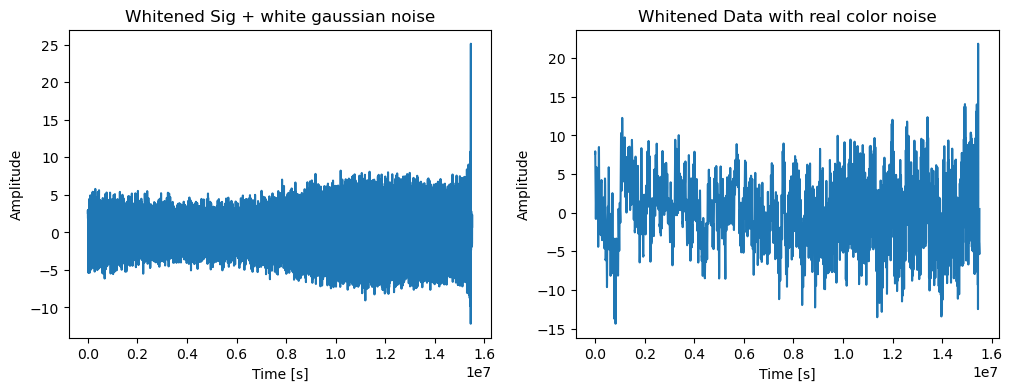

In [13]:

f,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
axes[0].plot(TimeVector,white_data[1:N])
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Whitened Sig + white gaussian noise')
axes[1].plot(TimeVector,White_Data_t[1:N])
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Whitened Data with real color noise')